Import Libraries

In [1]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Linear Regression models
from sklearn.linear_model import LinearRegression

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

Data preprocessing

Read data

In [2]:
df = pd.read_csv('Apple_clean.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200


Reset index

In [3]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the Close column as dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)
df_Close.head()


,Close
0,7.526071
1,7.643214
2,7.656429
3,7.534643
4,7.520714


Data normalization

In [4]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

Data splitting

In [5]:
# Split data into training, validation, and test sets (6:2:2)
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

Model training and testing

Training process

In [6]:
# Prepare training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

# Train Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R-squared:", model.score(x_train, y_train))

Intercept: -0.0034918336232137026
Coefficients: [6.38614721e-05]
R-squared: 0.8778943969883614


Testing process

In [7]:
# Validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(x_val)

# Evaluate
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv, y_pred_val_inv)

print(f"MAPE (Validation): {val_mape}")
print(f"RMSE (Validation): {val_rmse}")
print(f"MSLE (Validation): {val_msle}")


MAPE (Validation): 0.4949437565341788
RMSE (Validation): 73.44582164164777
MSLE (Validation): 0.6252056012984846


In [8]:
# Test data
x_test = np.array(range(train_size + val_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred_test = model.predict(x_test)

# Evaluate
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test_inv, y_pred_test_inv)

print(f"MAPE (Test): {test_mape}")
print(f"RMSE (Test): {test_rmse}")
print(f"MSLE (Test): {test_msle}")


MAPE (Test): 0.652616142836216
RMSE (Test): 131.32216663200543
MSLE (Test): 1.1299491518094982


Predicting the next 30 days

In [9]:
# Create index for next 30 days
last_index = df_Close.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

Preparing the prediction data

Prediction process

In [10]:
# Predict next 30 days
y_next_30_days = model.predict(x_next_30_days)
y_next_30_days_inv = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))

print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_inv.flatten())


Predicted closing prices for the next 30 days:
[72.60510203 72.62184274 72.63858346 72.65532417 72.67206489 72.6888056
 72.70554631 72.72228703 72.73902774 72.75576846 72.77250917 72.78924989
 72.8059906  72.82273132 72.83947203 72.85621275 72.87295346 72.88969418
 72.90643489 72.92317561 72.93991632 72.95665703 72.97339775 72.99013846
 73.00687918 73.02361989 73.04036061 73.05710132 73.07384204 73.09058275]


Preparing the forecast date index

In [11]:
# Generate future date index
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

Visualization

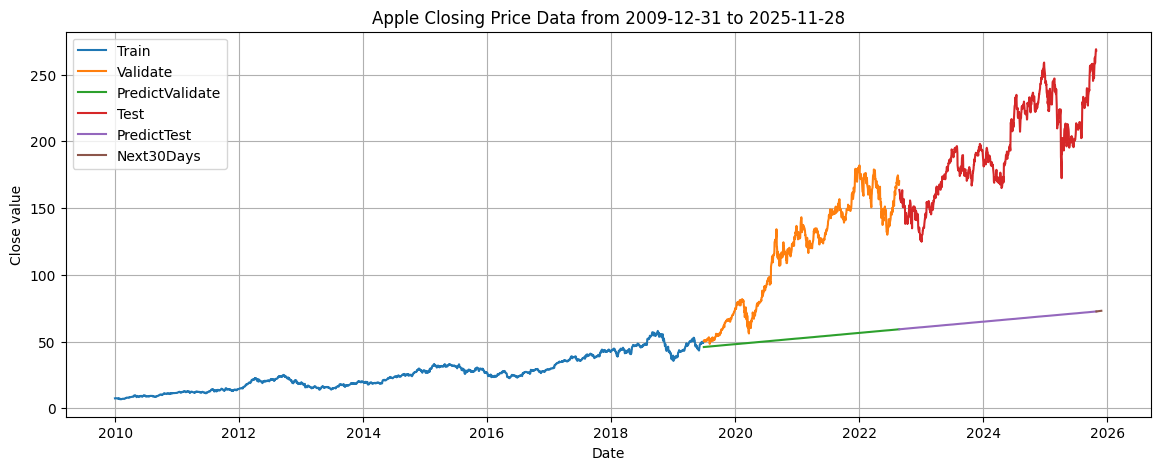

In [12]:
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(df.index[train_size:train_size + val_size], y_val_inv)
plt.plot(df.index[train_size:train_size + val_size], y_pred_val_inv)
plt.plot(df.index[train_size + val_size:], y_test_inv)
plt.plot(df.index[train_size + val_size:], y_pred_test_inv)
plt.plot(index_next_30_days, y_next_30_days_inv)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Days'])
plt.grid()
plt.title(f"Apple Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('LR_622_Apple.png')
plt.show()
